In [1]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback

os              : Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.31
python          : 3.9.17
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
sklearn         : 1.3.0
torch           : 2.0.1+cu117
device          : 1 gpu (['NVIDIA GeForce RTX 2060 with Max-Q Design'])
cpu cores       : 6
threads per cpu : 2
RAM             : 15.51 GB
GPU memory      : [6.0] GB


# Forecast SolAP

> 6- day horizon, hourly based

In [2]:
cwd = os.getcwd()
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_geo = yaml2dict('./config/solap.yaml', attrdict=True)
config_geo = config_geo.train
# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base, **config_geo})
# Add the architecture config
if config.arch_config_file is not None:
    config.arch_config_file = Path(config.arch_config_file)
    if config.arch_config_file.exists():
        config.arch = yaml2dict(config.arch_config_file, attrdict=True)
    else:
        print(f'No custom arch config found in {config.arch_config_file}')
        config.arch = AttrDict()
else:
    config.arch = AttrDict()
config

```json
{ 'add_time_channels': False,
  'arch': { 'decomposition': True,
            'individual': True,
            'padding_patch': True,
            'revin': True},
  'arch_config_file': Path('config/patchtst.yaml'),
  'arch_name': 'PatchTST',
  'bs': 1024,
  'horizon': 48,
  'init_weights': False,
  'lookback': 144,
  'lr_max': None,
  'n_epoch': 25,
  'partial_n': 0.001,
  'seed': 42,
  'solap': {'data_path': '../data/SOLRESAP.TXT', 'data_url': None},
  'test_end_datetime': '2018-12-31',
  'test_start_datetime': '2012-10-01',
  'valid_start_datetime': '2019-01-01',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [3]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config
print(config)

{'arch_name': 'PatchTST', 'arch_config_file': Path('config/patchtst.yaml'), 'bs': 1024, 'horizon': 48, 'init_weights': False, 'lookback': 144, 'lr_max': None, 'n_epoch': 25, 'partial_n': 0.001, 'seed': 42, 'test_start_datetime': '2012-10-01', 'test_end_datetime': '2018-12-31', 'valid_start_datetime': '2019-01-01', 'wandb': {'enabled': False, 'log_learner': True, 'mode': 'offline', 'group': None, 'project': 'swdf'}, 'add_time_channels': False, 'solap': {'data_url': None, 'data_path': '../data/SOLRESAP.TXT'}, 'arch': {'decomposition': True, 'individual': True, 'padding_patch': True, 'revin': True}}


In [4]:
fname_solap = config.solap.data_path if config.solap.data_url is None else download_data(
    config.solap.data_url, fname=config.solap.data_path)
fname_solap

'../data/SOLRESAP.TXT'

In [5]:
# Read the fname_solap file as a pandas dataframe.
# Ignore every line that starts with a space
# Column names:                                             DOY    F10    F81C    HOUR0    HOUR3    HOUR6    HOUR9    HOUR12    HOUR15    HOUR18    HOUR21    YYYY    F
df_data = pd.read_csv(fname_solap, sep='\s{2,}|\s', names=['DOY', 'F10', 'F81C', 'HOUR0', 'HOUR3', 'HOUR6', 'HOUR9', 'HOUR12', 'HOUR15', 'HOUR18', 'HOUR21', 'YEAR', 'F'])
# df_data['DATE'] = df_data.DATEandTIME.apply(str).map(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8])
# df_data['TIME'] = df_data.DATEandTIME.apply(str).map(lambda x: x[8:10] + ':' + x[10:12] + '00.000')
df_solap_raw = pd.DataFrame()
df_solap_raw['DATE'] = []
df_solap_raw['TIME'] = []
df_solap_raw['DOY'] = []
df_solap_raw['AP'] = []
for index, row in df_data.iterrows():
    day_num = str(row['DOY'])
    day_num.rjust(3 + len(day_num), '0')
    year = str(row['YEAR'])
    date = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")
    for hour in range(0,24,3):
        df_solap_raw.loc[int(8*index + hour/3)] = [date, str(hour)+':00:00.000', day_num, row['HOUR'+str(hour)]]
df_solap_raw

,DATE,TIME,DOY,AP
0,01-01-1997,0:00:00.000,1,7
1,01-01-1997,3:00:00.000,1,6
2,01-01-1997,6:00:00.000,1,3
3,01-01-1997,9:00:00.000,1,3
4,01-01-1997,12:00:00.000,1,4
...,...,...,...,...
76203,01-30-2023,9:00:00.000,30,3
76204,01-30-2023,12:00:00.000,30,3
76205,01-30-2023,15:00:00.000,30,3
76206,01-30-2023,18:00:00.000,30,3


In [6]:
# Check if there are any missing values
df_solap_raw.isna().sum()

DATE    0
TIME    0
DOY     0
AP      0
dtype: int64

In [7]:
# Distinct value of the column AP (classification problem?)
df_solap_raw.AP.unique().__len__()

31

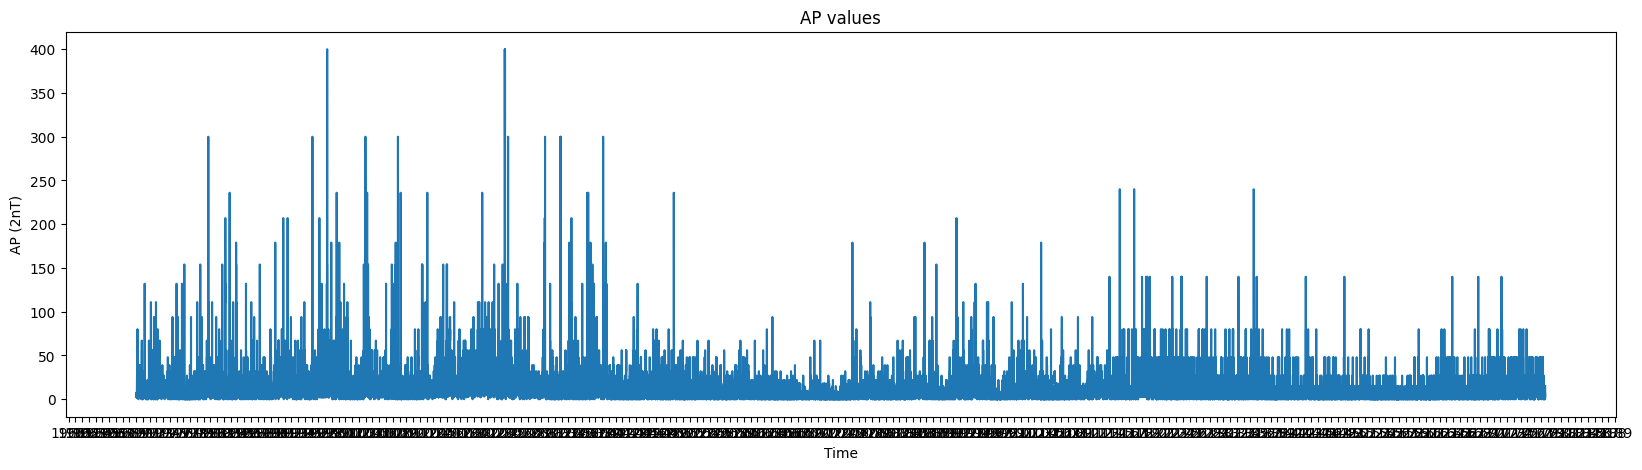

In [8]:
# hide

# Plot the AP values
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_solap_raw.AP)
ax.set_title('AP values')
ax.set_xlabel('Time')
ax.set_ylabel('AP (2nT)')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


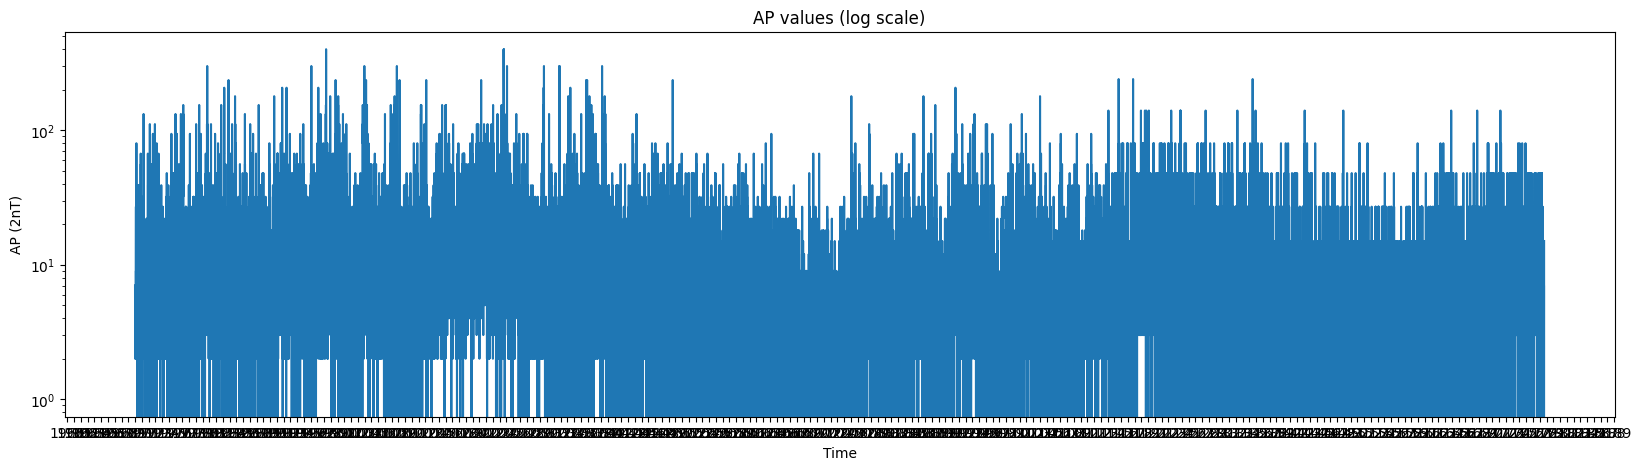

In [9]:
# hide

# Repeat the above plot but with a logarithmic scale
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_solap_raw.AP)
ax.set_title('AP values (log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('AP (2nT)')
ax.set_yscale('log')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


In [10]:
# Merge the DATE and TIME columns into a single datetime column. Save the result
# in a new dataframe, df, without the DATE and TIME columns.
df = df_solap_raw.copy()
df['datetime'] = pd.to_datetime(df.DATE + ' ' + df.TIME)
df.drop(columns=['DATE', 'TIME'], inplace=True)
df.head()

,DOY,AP,datetime
0,1,7,1997-01-01 00:00:00
1,1,6,1997-01-01 03:00:00
2,1,3,1997-01-01 06:00:00
3,1,3,1997-01-01 09:00:00
4,1,4,1997-01-01 12:00:00


In [11]:
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage and set the right dtypes
], verbose=True)

df = preproc_pipe.fit_transform(df)
df

Initial memory usage: 2.33 MB   
Final memory usage  : 1.46 MB    (-37.0%)
[Pipeline] .......... (step 1 of 1) Processing shrinker, total=   0.0s


,DOY,AP,datetime
0,1,7,1997-01-01 00:00:00
1,1,6,1997-01-01 03:00:00
2,1,3,1997-01-01 06:00:00
3,1,3,1997-01-01 09:00:00
4,1,4,1997-01-01 12:00:00
...,...,...,...
76203,30,3,2023-01-30 09:00:00
76204,30,3,2023-01-30 12:00:00
76205,30,3,2023-01-30 15:00:00
76206,30,3,2023-01-30 18:00:00


In [12]:
# In the paper by Licata et al. (2020) (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496),
# authors use a period from October 2012 through the end of 2018 for the benchmarking.
# Therefore, we will set the test set as the same period for our analysis, 
# using the column Date as the timestamp, from October 2012 to the end of 2018. 
# Everything before the test set will be used for training, and everything after the test set
# will be used for validation
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime
valid_start_datetime = config.valid_start_datetime

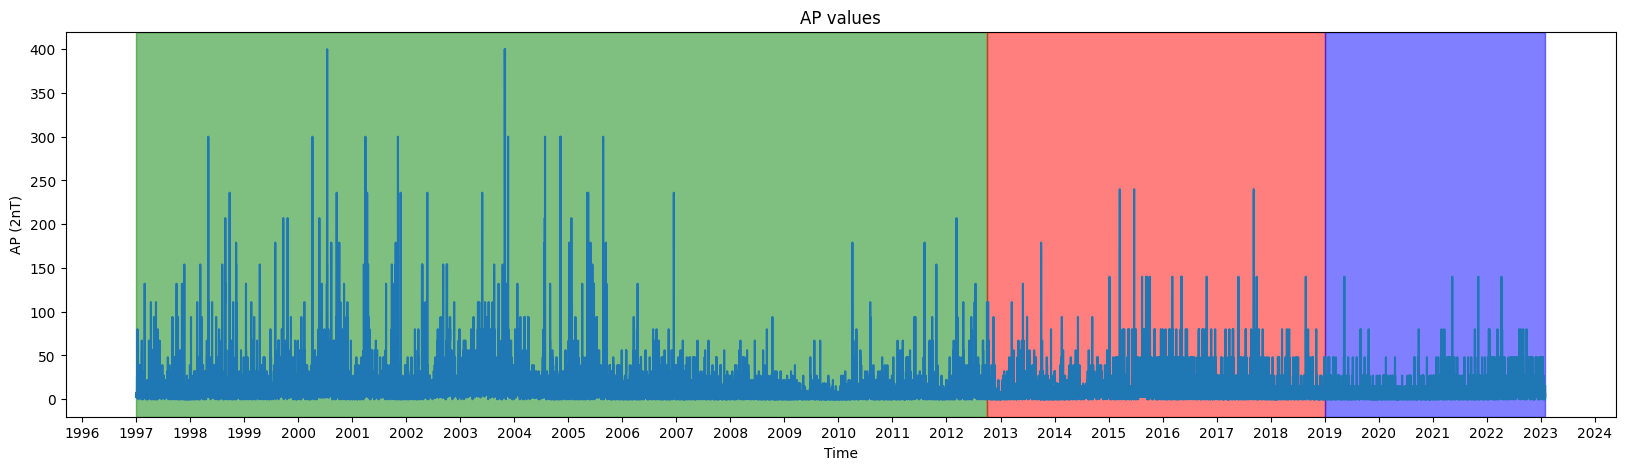

In [13]:
# hide

# Plot the variable AP, covering the different periods (training, test and validation)
# with different colors.
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df.datetime, df.AP)
ax.axvspan(df.datetime.min(), test_start_datetime, alpha=0.5, color='green')
ax.axvspan(test_start_datetime, test_end_datetime, alpha=0.5, color='red')
ax.axvspan(test_end_datetime, df.datetime.max(), alpha=0.5, color='blue')
ax.set_title('AP values')
ax.set_xlabel('Time')
ax.set_ylabel('AP (2nT)')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

In [14]:
# Splits: same as in solar flux (solfsmy) notebook

splits_ = get_forecasting_splits(df[df.datetime < valid_start_datetime], 
                             fcst_history=config.lookback, 
                             fcst_horizon=config.horizon, 
                             use_index=False, 
                             test_cutoff_datetime=test_start_datetime, 
                             show_plot=False, 
                             datetime_col='datetime')
foo = df[df.datetime >= valid_start_datetime]
bar = get_forecasting_splits(foo, config.lookback, config.horizon, valid_size=0.0, 
                             test_size=0.0, show_plot=False)
val_idxs = L(foo.index[bar[0]].tolist())

splits = (splits_[0], val_idxs, splits_[1])
splits

((#45826) [0,1,2,3,4,5,6,7,8,9...],
 (#11737) [64280,64281,64282,64283,64284,64285,64286,64287,64288,64289...],
 (#18216) [45873,45874,45875,45876,45877,45878,45879,45880,45881,45882...])

In [15]:
# Add or not add the time features
data_columns_fcst = ['AP']
data_columns_time = ['DOY']
data_columns = data_columns_fcst + data_columns_time if config.add_time_channels else data_columns_fcst
data_columns

['AP']

In [16]:
# Now that we have defined the splits for this particular experiment, we'll scale
# the data
train_split = splits[0]
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)
save_object(exp_pipe, 'tmp/exp_pipe.pkl')
exp_pipe = load_object('tmp/exp_pipe.pkl')
# TODO: I don't know why but if I don't copy the dataframe df it gets modified
df_scaled = exp_pipe.fit_transform(df.copy(), scaler__idxs = train_split)
#df_scaled.set_index(datetime_col, inplace=True)
df_scaled.head()

tmp directory already exists.
Pipeline saved as tmp/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,DOY,AP,datetime
0,1,-0.221381,1997-01-01 00:00:00
1,1,-0.279172,1997-01-01 03:00:00
2,1,-0.452544,1997-01-01 06:00:00
3,1,-0.452544,1997-01-01 09:00:00
4,1,-0.394753,1997-01-01 12:00:00


In [17]:
# We'll approach the time series forecasting task as a supervised learning problem. 
# Remember that tsai requires that both inputs and outputs have the following shape:
# (samples, features, steps)

# To get those inputs and outputs we're going to use a function called 
# `prepare_forecasting_data`` that applies a sliding window along the dataframe
X, y = prepare_forecasting_data(df, fcst_history=config.lookback, fcst_horizon=config.horizon, 
                                x_vars=data_columns, y_vars=data_columns_fcst)
X = X.astype(float)
y = y.astype(float)
X.shape, y.shape

((76017, 1, 144), (76017, 1, 48))

### Train

In [18]:
wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs, 
                     pipelines=[preproc_pipe, exp_pipe], arch=config.arch_name, 
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
learn.dls[0].partial_n, learn.dls[1].partial_n, learn.dls[2].partial_n

(46, None, None)

In [19]:
default_device()

device(type='cuda', index=0)

7.585775892948732e-05
#params: 13530220


epoch,train_loss,valid_loss,time
0,638.431641,101.357910,00:03
1,502.166992,100.975601,00:03
2,502.006958,101.509438,00:03
3,420.979553,104.626839,00:03
4,397.643890,111.005669,00:03
5,375.213348,127.337067,00:03
6,402.492096,130.119110,00:03
7,386.154144,162.335663,00:03
8,405.803986,218.324234,00:03
9,410.289551,282.134369,00:04


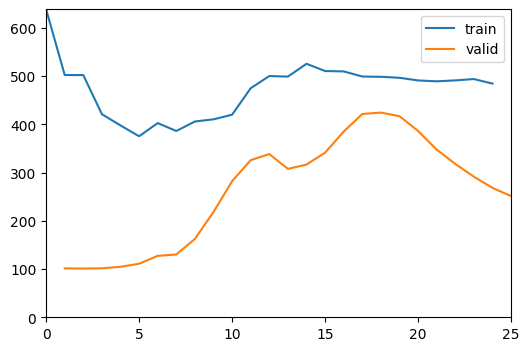

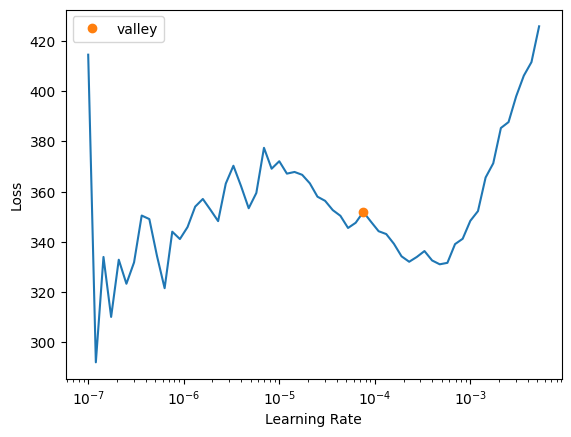

In [20]:
wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs, 
                     pipelines=[preproc_pipe, exp_pipe], arch=config.arch_name, 
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
learn.dls[0].partial_n, learn.dls[1].partial_n, learn.dls[2].partial_n
lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max
print(lr_max)
print(f"#params: {sum(p.numel() for p in learn.model.parameters())}")
learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)

In [21]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = learn.validate()[0] 
print(valid_loss)
%store valid_loss

251.1878204345703
Stored 'valid_loss' (float)


In [22]:
# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]
print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

460.79632568359375


In [23]:
# Save everything
# learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder
# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

# Save locally and in wandb if online and enabled
learn.save_all(path='tmp', verbose=True) 
if run is not None and config.wandb.log_learner:
    # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
    run.log_artifact('tmp', type='learner', name='Ap')
    

Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [24]:
if run is not None:
    run.finish()